# Checkpoint 4: Proximal Policy Optimization (PPO)

In this notebook, we'll use Proximal Policy Optimization (PPO) with Stable Baselines3 to train an agent to land on the moon in the LunarLander environment.

**Learning Objectives:**
- Understand the problems with vanilla policy gradients
- Learn how PPO's clipped objective solves these problems
- Understand Generalized Advantage Estimation (GAE)
- Use Stable Baselines3 to train a PPO agent
- Monitor training with TensorBoard

In [1]:
# Install required dependencies
# Note: swig must be installed before box2d-py
!pip install swig --quiet
!pip install gymnasium[box2d] stable-baselines3 tensorboard torch numpy matplotlib box2d-py --quiet


[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python -m pip install --upgrade pip


In [2]:
# GPU Detection
import torch

def get_device():
    """Detect and return the best available device for Stable Baselines3."""
    if torch.cuda.is_available():
        device = "cuda"
        print(f"CUDA GPU detected: {torch.cuda.get_device_name(0)}")
        print(f"CUDA version: {torch.version.cuda}")
    elif torch.backends.mps.is_available():
        # Note: SB3 has limited MPS support, may fall back to CPU for some operations
        device = "mps"
        print("Apple Silicon MPS device detected")
        print("Note: Stable Baselines3 has limited MPS support")
    else:
        device = "cpu"
        print("No GPU detected, using CPU")
    
    print(f"PyTorch version: {torch.__version__}")
    print(f"Selected device: {device}")
    return device

device = get_device()

CUDA GPU detected: NVIDIA GeForce RTX 3090
CUDA version: 12.4
PyTorch version: 2.4.1+cu124
Selected device: cuda


In [3]:
# Imports
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime

# Stable Baselines3 imports
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.callbacks import EvalCallback, CheckpointCallback
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor

# Set random seeds
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

print("All imports successful!")
print(f"Gymnasium version: {gym.__version__}")

import stable_baselines3
print(f"Stable Baselines3 version: {stable_baselines3.__version__}")

All imports successful!
Gymnasium version: 1.2.3
Stable Baselines3 version: 2.7.1


## Theory: Problems with Vanilla Policy Gradients

In the previous checkpoint, we implemented REINFORCE. While it works, it has significant issues:

### 1. High Variance

Monte Carlo returns can vary dramatically between episodes, leading to:
- Noisy gradient estimates
- Slow, unstable learning
- Difficulty in credit assignment

### 2. Sample Inefficiency

Being on-policy means:
- Cannot reuse old experiences
- Need fresh samples after every update
- Wasteful of computation

### 3. Destructive Updates

**This is the biggest problem!**

With vanilla policy gradients, a single bad update can:
- Drastically change the policy
- Collapse performance catastrophically
- Make recovery very difficult

```
Policy Performance
      |
  100 |     /\      /\
      |    /  \    /  \
   50 |   /    \  /    
      |  /      \/      \___  <- Catastrophic collapse!
    0 |_/                   
      +-----------------------> Training Steps
```

### The Key Insight

**We need to limit how much the policy can change in a single update!**

This is exactly what PPO does.

## Theory: PPO Clipped Objective

PPO (Proximal Policy Optimization) prevents destructive updates by clipping the objective function.

### The Probability Ratio

First, define the ratio between new and old policy:

$$r_t(\theta) = \frac{\pi_\theta(a_t|s_t)}{\pi_{\theta_{old}}(a_t|s_t)}$$

- If $r_t > 1$: New policy is more likely to take action $a_t$
- If $r_t < 1$: New policy is less likely to take action $a_t$
- If $r_t = 1$: No change

### The Clipped Objective

$$L^{CLIP}(\theta) = \mathbb{E}_t\left[\min\left(r_t(\theta)\hat{A}_t, \text{clip}(r_t(\theta), 1-\epsilon, 1+\epsilon)\hat{A}_t\right)\right]$$

Where:
- $\hat{A}_t$ is the advantage estimate
- $\epsilon$ is the clipping parameter (typically 0.2)
- $\text{clip}(r, 1-\epsilon, 1+\epsilon)$ constrains $r$ to $[0.8, 1.2]$

### How Clipping Works

```
Case 1: Advantage > 0 (good action, want to increase probability)

Objective
    |           _______
    |          /       <- Clipped! No more benefit beyond 1+epsilon
    |         /
    |        /
    |_______/
    +----------------> r_t(theta)
         1-e  1  1+e

Case 2: Advantage < 0 (bad action, want to decrease probability)

Objective
    |_______
    |       \         <- Clipped! No more penalty beyond 1-epsilon
    |        \
    |         \
    |          \_______
    +----------------> r_t(theta)
         1-e  1  1+e
```

### Why This Works

1. **Prevents too-large updates**: Policy ratio is constrained
2. **Conservative updates**: Takes minimum of clipped and unclipped
3. **Stable training**: No more catastrophic collapses!

## Theory: Generalized Advantage Estimation (GAE)

PPO uses GAE to estimate advantages, balancing bias and variance.

### The Advantage Function

The advantage tells us how much better an action is compared to the average:

$$A(s_t, a_t) = Q(s_t, a_t) - V(s_t)$$

### TD Residual

The temporal difference residual at timestep $t$:

$$\delta_t = r_t + \gamma V(s_{t+1}) - V(s_t)$$

### GAE Formula

GAE smoothly interpolates between different advantage estimators:

$$\hat{A}_t^{GAE(\gamma, \lambda)} = \sum_{l=0}^{\infty}(\gamma\lambda)^l\delta_{t+l}$$

Expanded:
$$\hat{A}_t = \delta_t + (\gamma\lambda)\delta_{t+1} + (\gamma\lambda)^2\delta_{t+2} + ...$$

### The Lambda Parameter

| $\lambda$ | Estimator Type | Bias | Variance |
|-----------|---------------|------|----------|
| 0 | 1-step TD | High | Low |
| 1 | Monte Carlo | Low | High |
| 0.95 | GAE (typical) | Balanced | Balanced |

### Intuition

- **Low $\lambda$ (0)**: Only look at immediate TD error (high bias, low variance)
- **High $\lambda$ (1)**: Look at all future TD errors (low bias, high variance)
- **$\lambda = 0.95$**: Good balance used in practice

## Theory: Key PPO Hyperparameters

| Parameter | Typical Value | Description |
|-----------|--------------|-------------|
| `learning_rate` | 3e-4 | Step size for gradient descent |
| `n_steps` | 2048 | Steps to collect before each update |
| `batch_size` | 64 | Minibatch size for gradient updates |
| `n_epochs` | 10 | Number of passes over collected data |
| `gamma` | 0.99 | Discount factor for future rewards |
| `gae_lambda` | 0.95 | GAE lambda for advantage estimation |
| `clip_range` | 0.2 | PPO clipping parameter (epsilon) |
| `ent_coef` | 0.0 | Entropy bonus coefficient |
| `vf_coef` | 0.5 | Value function loss coefficient |
| `max_grad_norm` | 0.5 | Gradient clipping threshold |

### Parameter Relationships

1. **n_steps x n_envs** = Total samples per update
2. **batch_size** divides (n_steps x n_envs) evenly
3. **n_epochs** = How many times to reuse each sample

### Tips for Tuning

- **Learning too slow?** Increase `learning_rate` or `n_epochs`
- **Unstable training?** Decrease `clip_range` or `learning_rate`
- **Not exploring enough?** Increase `ent_coef`
- **Memory issues?** Decrease `n_steps` or `batch_size`

In [4]:
# Create vectorized LunarLander environment
# Using 4 parallel environments for faster training

NUM_ENVS = 4
ENV_ID = "LunarLander-v3"

# Create vectorized environment
vec_env = make_vec_env(
    ENV_ID,
    n_envs=NUM_ENVS,
    seed=SEED
)

print(f"Environment: {ENV_ID}")
print(f"Number of parallel environments: {NUM_ENVS}")
print(f"\nObservation space: {vec_env.observation_space}")
print(f"Action space: {vec_env.action_space}")

# Describe the observation space
print("\nObservation components:")
obs_descriptions = [
    "x position",
    "y position",
    "x velocity",
    "y velocity",
    "angle",
    "angular velocity",
    "left leg contact",
    "right leg contact"
]
for i, desc in enumerate(obs_descriptions):
    print(f"  [{i}] {desc}")

print("\nAction meanings:")
action_meanings = [
    "0: Do nothing",
    "1: Fire left engine",
    "2: Fire main engine",
    "3: Fire right engine"
]
for meaning in action_meanings:
    print(f"  {meaning}")

Environment: LunarLander-v3
Number of parallel environments: 4

Observation space: Box([ -2.5        -2.5       -10.        -10.         -6.2831855 -10.
  -0.         -0.       ], [ 2.5        2.5       10.        10.         6.2831855 10.
  1.         1.       ], (8,), float32)
Action space: Discrete(4)

Observation components:
  [0] x position
  [1] y position
  [2] x velocity
  [3] y velocity
  [4] angle
  [5] angular velocity
  [6] left leg contact
  [7] right leg contact

Action meanings:
  0: Do nothing
  1: Fire left engine
  2: Fire main engine
  3: Fire right engine


In [5]:
# Create PPO model with explained hyperparameters

# Create log directories
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
log_dir = f"./logs/ppo_lunarlander_{timestamp}"
tensorboard_log = f"./tensorboard/ppo_lunarlander_{timestamp}"

os.makedirs(log_dir, exist_ok=True)
os.makedirs(tensorboard_log, exist_ok=True)

# Initialize PPO model
model = PPO(
    policy="MlpPolicy",           # Multi-layer perceptron policy
    env=vec_env,
    
    # Learning parameters
    learning_rate=3e-4,            # Step size for optimizer
    n_steps=2048,                  # Steps per environment per update
    batch_size=64,                 # Minibatch size
    n_epochs=10,                   # Epochs per update
    
    # Discount and advantage
    gamma=0.99,                    # Discount factor
    gae_lambda=0.95,               # GAE lambda
    
    # PPO specific
    clip_range=0.2,                # Clipping parameter
    clip_range_vf=None,            # Value function clipping (None = no clipping)
    
    # Loss coefficients
    ent_coef=0.0,                  # Entropy bonus
    vf_coef=0.5,                   # Value function coefficient
    
    # Gradient clipping
    max_grad_norm=0.5,             # Max gradient norm
    
    # Other
    tensorboard_log=tensorboard_log,
    verbose=1,
    seed=SEED,
    device=device if device != "mps" else "cpu"  # SB3 MPS support is limited
)

print("PPO Model created!")
print(f"\nPolicy architecture:")
print(model.policy)
print(f"\nTotal parameters: {sum(p.numel() for p in model.policy.parameters()):,}")
print(f"\nTensorBoard logs: {tensorboard_log}")

Using cuda device
PPO Model created!

Policy architecture:
ActorCriticPolicy(
  (features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (pi_features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (vf_features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (mlp_extractor): MlpExtractor(
    (policy_net): Sequential(
      (0): Linear(in_features=8, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): Tanh()
    )
    (value_net): Sequential(
      (0): Linear(in_features=8, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): Tanh()
    )
  )
  (action_net): Linear(in_features=64, out_features=4, bias=True)
  (value_net): Linear(in_features=64, out_features=1, bias=True)
)

Total parameters: 9,797

TensorBoard logs: ./tensorboard/ppo_lunarlander_2

/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


In [6]:
# Setup callbacks for evaluation and checkpointing

# Create evaluation environment (separate from training)
eval_env = make_vec_env(ENV_ID, n_envs=1, seed=SEED + 100)

# Evaluation callback - evaluates every 10k steps, saves best model
eval_callback = EvalCallback(
    eval_env,
    best_model_save_path=f"{log_dir}/best_model",
    log_path=f"{log_dir}/eval_results",
    eval_freq=10000 // NUM_ENVS,  # Evaluate every 10k total steps
    n_eval_episodes=10,            # Average over 10 episodes
    deterministic=True,            # Use deterministic actions for eval
    render=False
)

# Checkpoint callback - saves model every 25k steps
checkpoint_callback = CheckpointCallback(
    save_freq=25000 // NUM_ENVS,   # Save every 25k total steps
    save_path=f"{log_dir}/checkpoints",
    name_prefix="ppo_lunarlander"
)

print("Callbacks configured!")
print(f"\nEvalCallback:")
print(f"  - Evaluates every 10,000 timesteps")
print(f"  - Runs 10 evaluation episodes")
print(f"  - Saves best model to: {log_dir}/best_model")
print(f"\nCheckpointCallback:")
print(f"  - Saves every 25,000 timesteps")
print(f"  - Checkpoints at: {log_dir}/checkpoints")

Callbacks configured!

EvalCallback:
  - Evaluates every 10,000 timesteps
  - Runs 10 evaluation episodes
  - Saves best model to: ./logs/ppo_lunarlander_20260119_071351/best_model

CheckpointCallback:
  - Saves every 25,000 timesteps
  - Checkpoints at: ./logs/ppo_lunarlander_20260119_071351/checkpoints


In [7]:
pip install tqdm rich                                                                                                                


[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [8]:
  pip install stable-baselines3[extra]                                                                                                 


[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [9]:
# Train for 100k timesteps with progress bar

TOTAL_TIMESTEPS = 100_000


print("="*60)
print("Starting PPO Training on LunarLander-v3")
print("="*60)
print(f"\nTotal timesteps: {TOTAL_TIMESTEPS:,}")
print(f"Parallel environments: {NUM_ENVS}")
print(f"Steps per update: {model.n_steps * NUM_ENVS:,}")
print(f"Expected updates: {TOTAL_TIMESTEPS // (model.n_steps * NUM_ENVS)}")
print("\n" + "-"*60 + "\n")

# Train the model
model.learn(
    total_timesteps=TOTAL_TIMESTEPS,
    callback=[eval_callback, checkpoint_callback],
    progress_bar=True
)

print("\n" + "="*60)
print("Training Complete!")
print("="*60)

# Save final model
final_model_path = f"{log_dir}/final_model"
model.save(final_model_path)
print(f"\nFinal model saved to: {final_model_path}")

Starting PPO Training on LunarLander-v3

Total timesteps: 100,000
Parallel environments: 4
Steps per update: 8,192
Expected updates: 12

------------------------------------------------------------

Logging to ./tensorboard/ppo_lunarlander_20260119_071351/PPO_1


Output()

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 93       |
|    ep_rew_mean     | -182     |
| time/              |          |
|    fps             | 2278     |
|    iterations      | 1        |
|    time_elapsed    | 3        |
|    total_timesteps | 8192     |
---------------------------------


Eval num_timesteps=10000, episode_reward=-236.21 +/- 187.47

Episode length: 256.50 +/- 98.79

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 256          |
|    mean_reward          | -236         |
| time/                   |              |
|    total_timesteps      | 10000        |
| train/                  |              |
|    approx_kl            | 0.0069920123 |
|    clip_fraction        | 0.0568       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.38        |
|    explained_variance   | 0.000672     |
|    learning_rate        | 0.0003       |
|    loss                 | 269          |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.00675     |
|    value_loss           | 1.05e+03     |
------------------------------------------


New best mean reward!

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 98.7     |
|    ep_rew_mean     | -174     |
| time/              |          |
|    fps             | 918      |
|    iterations      | 2        |
|    time_elapsed    | 17       |
|    total_timesteps | 16384    |
---------------------------------


Eval num_timesteps=20000, episode_reward=-2468.88 +/- 1616.79

Episode length: 442.50 +/- 126.11

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 442         |
|    mean_reward          | -2.47e+03   |
| time/                   |             |
|    total_timesteps      | 20000       |
| train/                  |             |
|    approx_kl            | 0.010801893 |
|    clip_fraction        | 0.0776      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.36       |
|    explained_variance   | 0.146       |
|    learning_rate        | 0.0003      |
|    loss                 | 135         |
|    n_updates            | 20          |
|    policy_gradient_loss | -0.00823    |
|    value_loss           | 585         |
-----------------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 103      |
|    ep_rew_mean     | -139     |
| time/              |          |
|    fps             | 705      |
|    iterations      | 3        |
|    time_elapsed    | 34       |
|    total_timesteps | 24576    |
---------------------------------


Eval num_timesteps=30000, episode_reward=-4841.48 +/- 2511.29

Episode length: 523.50 +/- 123.94

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 524         |
|    mean_reward          | -4.84e+03   |
| time/                   |             |
|    total_timesteps      | 30000       |
| train/                  |             |
|    approx_kl            | 0.011126056 |
|    clip_fraction        | 0.0996      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.33       |
|    explained_variance   | 0.239       |
|    learning_rate        | 0.0003      |
|    loss                 | 79.7        |
|    n_updates            | 30          |
|    policy_gradient_loss | -0.0116     |
|    value_loss           | 253         |
-----------------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 109      |
|    ep_rew_mean     | -102     |
| time/              |          |
|    fps             | 625      |
|    iterations      | 4        |
|    time_elapsed    | 52       |
|    total_timesteps | 32768    |
---------------------------------


Eval num_timesteps=40000, episode_reward=-2730.20 +/- 1312.72

Episode length: 349.10 +/- 75.50

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 349         |
|    mean_reward          | -2.73e+03   |
| time/                   |             |
|    total_timesteps      | 40000       |
| train/                  |             |
|    approx_kl            | 0.011851347 |
|    clip_fraction        | 0.147       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.29       |
|    explained_variance   | 0.338       |
|    learning_rate        | 0.0003      |
|    loss                 | 58.6        |
|    n_updates            | 40          |
|    policy_gradient_loss | -0.0173     |
|    value_loss           | 189         |
-----------------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 114      |
|    ep_rew_mean     | -81.7    |
| time/              |          |
|    fps             | 617      |
|    iterations      | 5        |
|    time_elapsed    | 66       |
|    total_timesteps | 40960    |
---------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 136         |
|    ep_rew_mean          | -63         |
| time/                   |             |
|    fps                  | 638         |
|    iterations           | 6           |
|    time_elapsed         | 76          |
|    total_timesteps      | 49152       |
| train/                  |             |
|    approx_kl            | 0.014229216 |
|    clip_fraction        | 0.202       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.22       |
|    explained_variance   | 0.427       |
|    learning_rate        | 0.0003      |
|    loss                 | 71.8        |
|    n_updates            | 50          |
|    policy_gradient_loss | -0.0176     |
|    value_loss           | 171         |
-----------------------------------------


Eval num_timesteps=50000, episode_reward=-1022.96 +/- 521.59

Episode length: 544.40 +/- 212.87

----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 544        |
|    mean_reward          | -1.02e+03  |
| time/                   |            |
|    total_timesteps      | 50000      |
| train/                  |            |
|    approx_kl            | 0.01354533 |
|    clip_fraction        | 0.203      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.17      |
|    explained_variance   | 0.48       |
|    learning_rate        | 0.0003     |
|    loss                 | 61.7       |
|    n_updates            | 60         |
|    policy_gradient_loss | -0.0169    |
|    value_loss           | 173        |
----------------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 161      |
|    ep_rew_mean     | -44.3    |
| time/              |          |
|    fps             | 569      |
|    iterations      | 7        |
|    time_elapsed    | 100      |
|    total_timesteps | 57344    |
---------------------------------


Eval num_timesteps=60000, episode_reward=-951.02 +/- 352.81

Episode length: 437.40 +/- 143.08

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 437         |
|    mean_reward          | -951        |
| time/                   |             |
|    total_timesteps      | 60000       |
| train/                  |             |
|    approx_kl            | 0.016250458 |
|    clip_fraction        | 0.191       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.1        |
|    explained_variance   | 0.645       |
|    learning_rate        | 0.0003      |
|    loss                 | 44.3        |
|    n_updates            | 70          |
|    policy_gradient_loss | -0.015      |
|    value_loss           | 123         |
-----------------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 191      |
|    ep_rew_mean     | -37      |
| time/              |          |
|    fps             | 549      |
|    iterations      | 8        |
|    time_elapsed    | 119      |
|    total_timesteps | 65536    |
---------------------------------


Eval num_timesteps=70000, episode_reward=-624.13 +/- 178.69

Episode length: 395.60 +/- 194.10

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 396         |
|    mean_reward          | -624        |
| time/                   |             |
|    total_timesteps      | 70000       |
| train/                  |             |
|    approx_kl            | 0.010369183 |
|    clip_fraction        | 0.113       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.09       |
|    explained_variance   | 0.686       |
|    learning_rate        | 0.0003      |
|    loss                 | 78.2        |
|    n_updates            | 80          |
|    policy_gradient_loss | -0.00862    |
|    value_loss           | 139         |
-----------------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 244      |
|    ep_rew_mean     | -40.7    |
| time/              |          |
|    fps             | 441      |
|    iterations      | 9        |
|    time_elapsed    | 167      |
|    total_timesteps | 73728    |
---------------------------------


Eval num_timesteps=80000, episode_reward=-452.10 +/- 209.04

Episode length: 558.30 +/- 268.25

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 558         |
|    mean_reward          | -452        |
| time/                   |             |
|    total_timesteps      | 80000       |
| train/                  |             |
|    approx_kl            | 0.009232932 |
|    clip_fraction        | 0.0808      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.12       |
|    explained_variance   | 0.642       |
|    learning_rate        | 0.0003      |
|    loss                 | 85          |
|    n_updates            | 90          |
|    policy_gradient_loss | -0.00718    |
|    value_loss           | 137         |
-----------------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 301      |
|    ep_rew_mean     | -42      |
| time/              |          |
|    fps             | 430      |
|    iterations      | 10       |
|    time_elapsed    | 190      |
|    total_timesteps | 81920    |
---------------------------------


Eval num_timesteps=90000, episode_reward=-501.91 +/- 222.28

Episode length: 497.00 +/- 207.95

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 497         |
|    mean_reward          | -502        |
| time/                   |             |
|    total_timesteps      | 90000       |
| train/                  |             |
|    approx_kl            | 0.013853351 |
|    clip_fraction        | 0.133       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.04       |
|    explained_variance   | 0.766       |
|    learning_rate        | 0.0003      |
|    loss                 | 62.6        |
|    n_updates            | 100         |
|    policy_gradient_loss | -0.00855    |
|    value_loss           | 86.9        |
-----------------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 352      |
|    ep_rew_mean     | -42.2    |
| time/              |          |
|    fps             | 419      |
|    iterations      | 11       |
|    time_elapsed    | 214      |
|    total_timesteps | 90112    |
---------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 422          |
|    ep_rew_mean          | -39          |
| time/                   |              |
|    fps                  | 420          |
|    iterations           | 12           |
|    time_elapsed         | 233          |
|    total_timesteps      | 98304        |
| train/                  |              |
|    approx_kl            | 0.0115968045 |
|    clip_fraction        | 0.094        |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.08        |
|    explained_variance   | 0.774        |
|    learning_rate        | 0.0003       |
|    loss                 | 41.2         |
|    n_updates            | 110          |
|    policy_gradient_loss | -0.00987     |
|    value_loss           | 70.6         |
------------------------------------------


Eval num_timesteps=100000, episode_reward=-399.15 +/- 68.42

Episode length: 972.60 +/- 82.20

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 973         |
|    mean_reward          | -399        |
| time/                   |             |
|    total_timesteps      | 100000      |
| train/                  |             |
|    approx_kl            | 0.007697554 |
|    clip_fraction        | 0.0924      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.05       |
|    explained_variance   | 0.754       |
|    learning_rate        | 0.0003      |
|    loss                 | 12.4        |
|    n_updates            | 120         |
|    policy_gradient_loss | -0.00812    |
|    value_loss           | 46.4        |
-----------------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 481      |
|    ep_rew_mean     | -35.4    |
| time/              |          |
|    fps             | 394      |
|    iterations      | 13       |
|    time_elapsed    | 270      |
|    total_timesteps | 106496   |
---------------------------------



Training Complete!

Final model saved to: ./logs/ppo_lunarlander_20260119_071351/final_model


In [10]:
# TensorBoard visualization
# Run this cell to launch TensorBoard inline

%load_ext tensorboard
%tensorboard --logdir ./tensorboard

In [11]:
# Evaluate the trained agent for 10 episodes

print("Evaluating trained agent...\n")

# Load best model (or use current if best not available)
best_model_path = f"{log_dir}/best_model/best_model.zip"
if os.path.exists(best_model_path):
    print(f"Loading best model from: {best_model_path}")
    eval_model = PPO.load(best_model_path)
else:
    print("Using current model for evaluation")
    eval_model = model

# Create fresh evaluation environment
eval_env_single = gym.make(ENV_ID)

# Evaluate
mean_reward, std_reward = evaluate_policy(
    eval_model,
    eval_env_single,
    n_eval_episodes=10,
    deterministic=True
)

print(f"\nEvaluation Results (10 episodes):")
print(f"  Mean reward: {mean_reward:.2f} +/- {std_reward:.2f}")

# Success criteria
if mean_reward >= 200:
    print("\nLunarLander-v3 SOLVED! (Mean reward >= 200)")
else:
    print(f"\nNot quite solved yet. Need mean reward >= 200")
    print("Try training for more timesteps or tuning hyperparameters.")

eval_env_single.close()

Evaluating trained agent...

Loading best model from: ./logs/ppo_lunarlander_20260119_071351/best_model/best_model.zip


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(



Evaluation Results (10 episodes):
  Mean reward: -286.15 +/- 267.36

Not quite solved yet. Need mean reward >= 200
Try training for more timesteps or tuning hyperparameters.


Capturing landing sequence...
Episode reward: -426.98
Episode length: 168 frames


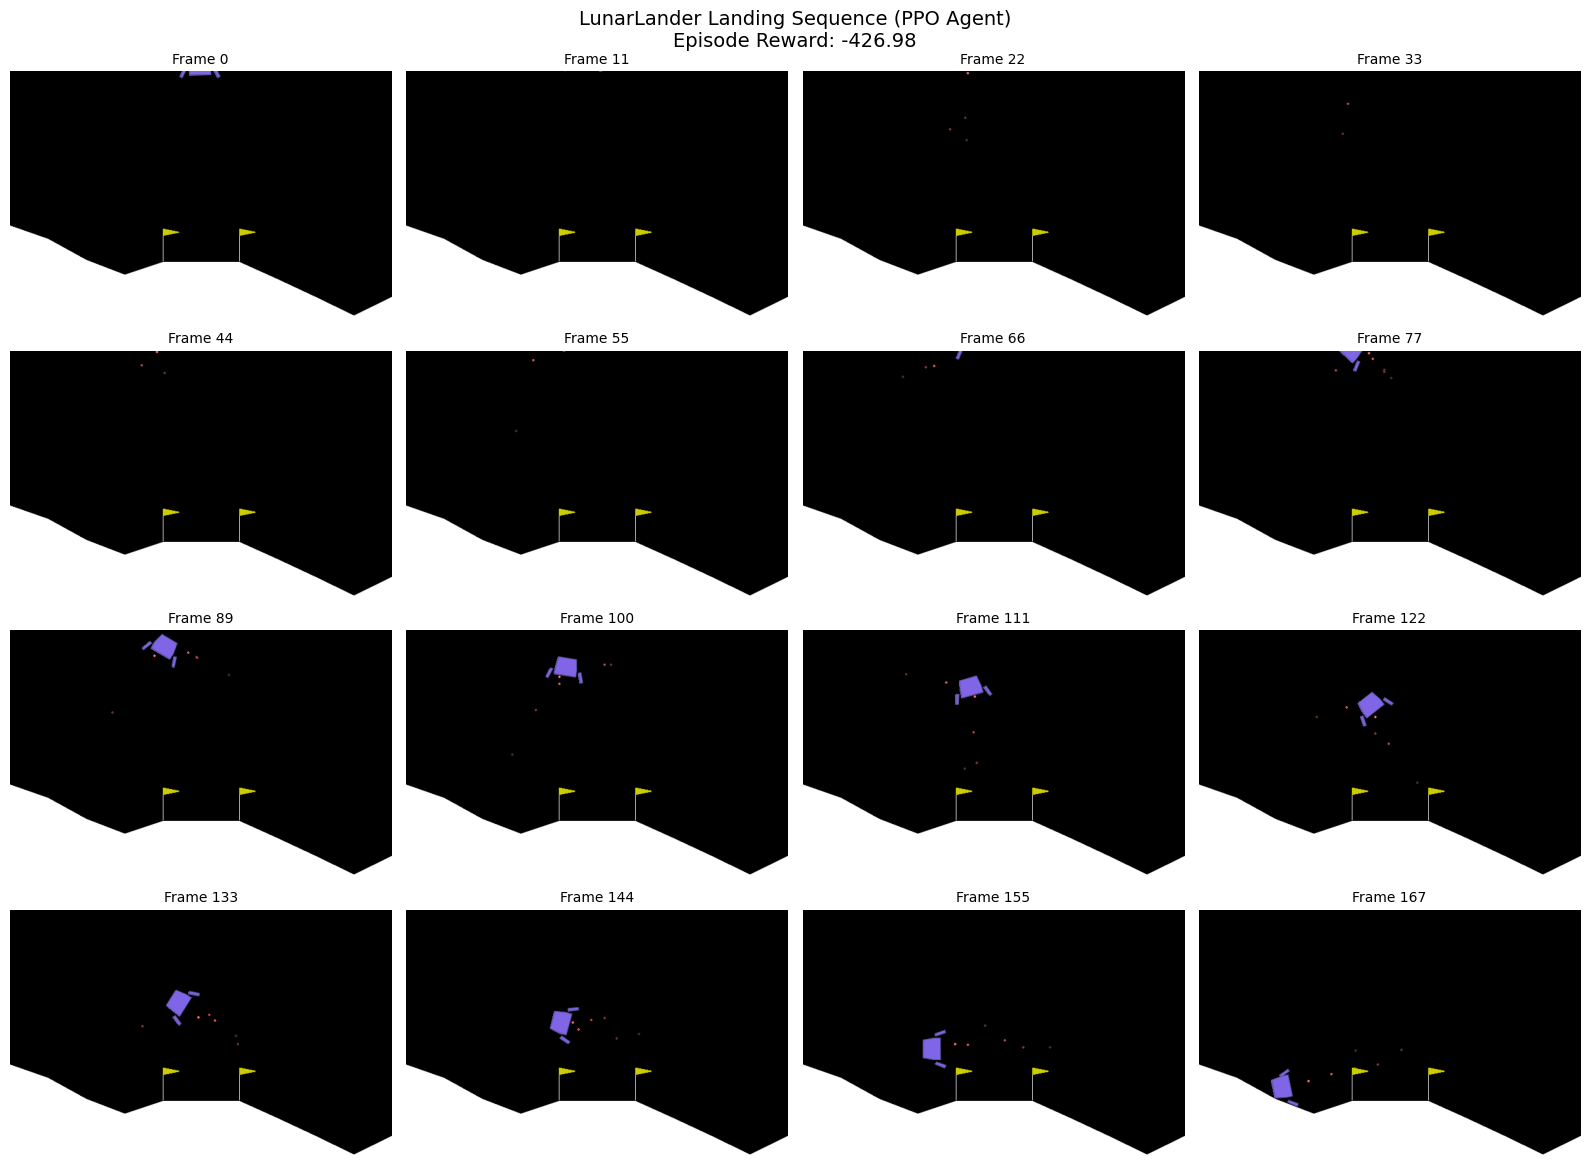

In [12]:
# Visualize a landing sequence

def capture_landing_frames(model, env_id, max_steps=1000):
    """
    Capture frames from a landing attempt.
    
    Args:
        model: Trained PPO model
        env_id: Environment ID
        max_steps: Maximum steps per episode
        
    Returns:
        frames: List of RGB frames
        total_reward: Episode reward
    """
    env = gym.make(env_id, render_mode="rgb_array")
    
    frames = []
    obs, _ = env.reset()
    total_reward = 0
    
    for step in range(max_steps):
        # Capture frame
        frame = env.render()
        frames.append(frame)
        
        # Get action from model
        action, _ = model.predict(obs, deterministic=True)
        
        # Take step
        obs, reward, terminated, truncated, _ = env.step(action)
        total_reward += reward
        
        if terminated or truncated:
            # Capture final frame
            frames.append(env.render())
            break
    
    env.close()
    return frames, total_reward

# Capture frames from best/current model
print("Capturing landing sequence...")
landing_frames, episode_reward = capture_landing_frames(
    eval_model if 'eval_model' in dir() else model,
    ENV_ID
)
print(f"Episode reward: {episode_reward:.2f}")
print(f"Episode length: {len(landing_frames)} frames")

# Display selected frames
def display_landing_sequence(frames, num_frames=16, figsize=(16, 12)):
    """
    Display a sequence of landing frames.
    """
    if len(frames) == 0:
        print("No frames to display!")
        return
    
    # Select evenly spaced frames
    indices = np.linspace(0, len(frames) - 1, num_frames, dtype=int)
    selected_frames = [frames[i] for i in indices]
    
    # Create subplot grid
    cols = 4
    rows = (num_frames + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = axes.flatten()
    
    for i, (ax, frame) in enumerate(zip(axes, selected_frames)):
        ax.imshow(frame)
        ax.set_title(f'Frame {indices[i]}', fontsize=10)
        ax.axis('off')
    
    # Hide empty subplots
    for i in range(len(selected_frames), len(axes)):
        axes[i].axis('off')
    
    plt.suptitle(f'LunarLander Landing Sequence (PPO Agent)\nEpisode Reward: {episode_reward:.2f}', 
                 fontsize=14)
    plt.tight_layout()
    plt.show()

display_landing_sequence(landing_frames)

## Quiz: Proximal Policy Optimization

Test your understanding of PPO and its components.

---

**Question 1:** What is the main purpose of the clipped objective in PPO?

A) To speed up training  
B) To prevent too-large policy updates that could collapse performance  
C) To reduce memory usage  
D) To handle continuous actions  

<details>
<summary>Click for answer</summary>

**B) To prevent too-large policy updates that could collapse performance**

The clipped objective constrains how much the policy can change in a single update. This prevents the destructive updates that plague vanilla policy gradients, where a single bad update can collapse performance.
</details>

---

**Question 2:** If the PPO clip_range is set to 0.2, what values can the probability ratio take?

A) [0, 0.2]  
B) [0.8, 1.2]  
C) [-0.2, 0.2]  
D) [0.2, 1.0]  

<details>
<summary>Click for answer</summary>

**B) [0.8, 1.2]**

With epsilon (clip_range) = 0.2, the probability ratio is clipped to [1 - epsilon, 1 + epsilon] = [0.8, 1.2]. This means the new policy probability can be at most 20% higher or lower than the old policy.
</details>

---

**Question 3:** What does GAE (Generalized Advantage Estimation) balance?

A) Speed and accuracy  
B) Bias and variance in advantage estimates  
C) Exploration and exploitation  
D) Policy and value learning rates  

<details>
<summary>Click for answer</summary>

**B) Bias and variance in advantage estimates**

GAE uses a lambda parameter to smoothly interpolate between high-bias/low-variance (TD) and low-bias/high-variance (Monte Carlo) advantage estimators. Lambda = 0.95 is typically used as a good balance.
</details>

---

**Question 4:** Why does PPO use multiple epochs (n_epochs) over the collected data?

A) To make training faster  
B) To improve sample efficiency by reusing data  
C) To prevent overfitting  
D) To reduce memory usage  

<details>
<summary>Click for answer</summary>

**B) To improve sample efficiency by reusing data**

Unlike vanilla policy gradients where data must be discarded after one update, PPO's clipped objective allows safe reuse of data for multiple gradient updates. This significantly improves sample efficiency.
</details>

---

**Question 5:** What is the advantage of using vectorized (parallel) environments?

A) Better graphics rendering  
B) Reduced memory usage  
C) Faster data collection and more diverse experience  
D) Simpler code  

<details>
<summary>Click for answer</summary>

**C) Faster data collection and more diverse experience**

Running multiple environments in parallel allows collecting more data per unit time. Additionally, the experiences are more diverse since different environments may be in different states, which can improve learning.
</details>

In [13]:
# Cleanup
print("Cleaning up resources...")

# Close environments
vec_env.close()
eval_env.close()

# Clear CUDA cache if using GPU
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    print("CUDA cache cleared")

# Optional: Clean up saved models and logs
# Uncomment the following lines if you want to delete training artifacts
# import shutil
# if os.path.exists(log_dir):
#     shutil.rmtree(log_dir)
#     print(f"Deleted {log_dir}")
# if os.path.exists(tensorboard_log):
#     shutil.rmtree(tensorboard_log)
#     print(f"Deleted {tensorboard_log}")

print("\nCleanup complete!")
print(f"\nTraining artifacts saved at:")
print(f"  - Model checkpoints: {log_dir}")
print(f"  - TensorBoard logs: {tensorboard_log}")

Cleaning up resources...
CUDA cache cleared

Cleanup complete!

Training artifacts saved at:
  - Model checkpoints: ./logs/ppo_lunarlander_20260119_071351
  - TensorBoard logs: ./tensorboard/ppo_lunarlander_20260119_071351


## Summary

In this checkpoint, we learned:

### Key Concepts

1. **Problems with Vanilla Policy Gradients**
   - High variance from Monte Carlo returns
   - Sample inefficiency (on-policy)
   - Destructive updates can collapse performance

2. **PPO's Clipped Objective**
   - Constrains how much policy can change
   - Uses probability ratio between new and old policy
   - Takes conservative (minimum) of clipped and unclipped objective

3. **Generalized Advantage Estimation (GAE)**
   - Balances bias and variance in advantage estimates
   - Lambda parameter interpolates between TD and Monte Carlo

4. **Practical PPO with Stable Baselines3**
   - Vectorized environments for parallel data collection
   - Callbacks for evaluation and checkpointing
   - TensorBoard for monitoring training

### What's Next?

You now have a solid foundation in modern policy gradient methods. In the next checkpoints, we'll:

- Apply these techniques to more complex environments
- Learn about actor-critic architectures (A2C, A3C)
- Explore advanced topics like curiosity-driven exploration

---

**Congratulations on completing Checkpoint 4!**